# Mini Project 3  - IU 4.6 Machine Learning

## Packages and setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import scikitplot as skplt
from sklearn.naive_bayes import GaussianNB


#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## This notebook requires running the following command to install scikitplot.
## conda install -c conda-forge scikit-plot

## Reading data and initial processing

In [2]:
#edit the file location of raw data set
cust_df=pd.read_csv('Mini_project_3_Data.csv')

## Exercise

## Q1. Detect and resolve problems in the data (Missing value, Outliers, Unexpected value, etc.)

In [3]:
# Type your code here to explore and understand the data better

#e.g., identify the dimension of cust_df
print('The dataframe has',cust_df.shape[0],'rows and',cust_df.shape[1] ,'columns\n')
#Print number of rows in cust_df
print('Total number of unique customer records :',cust_df.CustomerID.nunique(),'\n')
#Print number of features in cust_df
print('Total number of features :',cust_df.shape[1]-1,'(excluding \'Churn\')\n')
#Print total number of missing values
#print(f"Missing Values: {cust_df.isnull().values.sum()} \n")
print('Total number of MISSING values :',cust_df.isnull().values.sum(),'\n')
#Print number of unique values per feature
#print('Total number of UNIQUE values for each feature:\n',cust_df.nunique(),'\n')

The dataframe has 51047 rows and 58 columns

Total number of unique customer records : 51047 

Total number of features : 57 (excluding 'Churn')

Total number of MISSING values : 3515 



## Checking if our churn breakdown is balanced.

In [4]:
churn_brkdown = cust_df.Churn
churn_brkdown.value_counts()/len(churn_brkdown)*100

No     71.18146
Yes    28.81854
Name: Churn, dtype: float64

Looks like there is a class imbalance for Churn.

### Q1.1 How many customers had zero monthly revenue?

In [5]:
#How many customers had zero monthly revenue?

mthly_rev_lte0 = (cust_df['MonthlyRevenue'] <= 0).sum()

print(mthly_rev_lte0,'customers had zero or negative monthly revenue')

9 customers had zero or negative monthly revenue


In [6]:
#Exclude the customers with zero monthly revenue from cust_df and from any subsequent analysis

cust_df = cust_df[ cust_df['MonthlyRevenue'] > 0 ]

In [7]:
# Drop 156 rows of NaN values in Monthly Revenue (=0.3% of observations)
cust_df=cust_df.dropna(subset=['MonthlyRevenue']) # 50882 by 58 
cust_df.shape

(50882, 58)

### Q1.2 How many columns has missing values percentage > 5%

In [8]:
#Calculate for each column % of missing value in the data
#How many columns has missing values percentage > 5%
#What strategy should be used for imputation?

## These two columns have values with 'Unknown' and are replaced with NaN values before computation of % missing values

cust_df = cust_df.replace({
                'HandsetPrice':'Unknown',
                'MaritalStatus':'Unknown'
                },np.NaN)

In [9]:
dict_cols={}
for col in cust_df.columns:
    x = cust_df[col].isnull().sum()/cust_df.shape[0] *100 # percent null in that col
    if x> 5:
        dict_cols[col] = str(round(x,2))+'%'
print('The columns with missing values greater than 5% are:',dict_cols)

The columns with missing values greater than 5% are: {'HandsetPrice': '56.83%', 'MaritalStatus': '38.6%'}


<mark>__Result:__
    
- There are 2 columns with missing values > 5%:'HandsetPrice': '56.83%', 'MaritalStatus': '38.6%'  
    
Strategy for imputation:
1. For columns that are NOT significant and have missing values more than 30%, we will remove them.
2. For numerical columns, we can interpolate or use mean, median , etc to interpolate the missing values
3. For categorical, we can use mode to impute these missing values
4. KNN can also be used to fill in the missing values

### Q1.3 For columns, "UniqueSubs" and "DirectorAssistedCalls" remove outliers, if any

<AxesSubplot:>

(50882, 58)

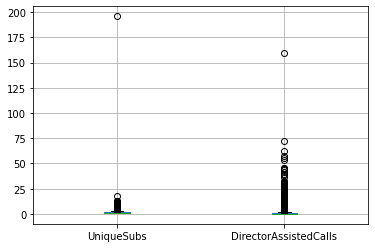

In [10]:
#plot box plot using pandas for columns "UniqueSubs" and "DirectorAssistedCalls"
cols=["UniqueSubs","DirectorAssistedCalls"]
cust_df.boxplot(column=cols)
cust_df.shape

There are too many outliers in the data, making it difficult to see the box plot whiskers and any potential analysis. Therefore, we will remove the top 1% outliers.

In [ ]:
#Remove top 1% outliers from the above mentioned two columns and plot the box plot again
#Use "quantile" function to identify top 1% outliers

In [11]:
# Check from which value data is have top 1% outliers

q_high = cust_df['UniqueSubs'].quantile(0.99)  # Top 1% data from UniqueSubs columns-> q_high is outlier

q_high1 = cust_df['DirectorAssistedCalls'].quantile(0.99) # Top 1% data from DirectorAssistedCalls columns-> q_high1 is outlier

# filter the data based on the condition
cust_df = cust_df[(cust_df['UniqueSubs']<q_high)]
cust_df = cust_df[(cust_df['DirectorAssistedCalls']<q_high1)]
cust_df.shape # 49 722 rows after dropping outliers

(49722, 58)

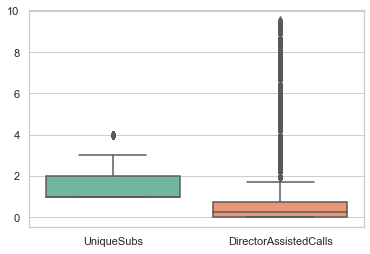

In [12]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sns.boxplot(data=cust_df[["UniqueSubs","DirectorAssistedCalls"]],orient="v",palette="Set2")
plt.show();

The revised boxplot above shows the UniqueSubs and director Assisted Calls after 1% outliers have been removed. The whiskers are now clearly visible in the plot.

## Q2. Perform exploratory analysis to analyze customer churn

### Q2.1 Does customers with high overage minutes also have high revenue?

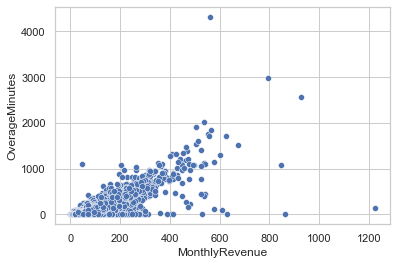

In [13]:
#use scatter plot to find the correlation between monthly revenue and overage minutes
sns.scatterplot(x = 'MonthlyRevenue', y = 'OverageMinutes', data = cust_df);

In [14]:
from scipy.stats import pearsonr
pearsonr(cust_df['MonthlyRevenue'], cust_df['OverageMinutes'])

(0.7843666867527471, 0.0)

<mark>__Result:__
    
There is a positive correlation between Monthly Revenue and Overage Minutes (correlation coefficient of 0.788). Customers with higher overage minutes will generate higher revenues. At alpha = 0.05, the Pearson's test shows that the correlation between both are statistically significant with a p-value of 0.0.

### Q2.2 Does high number of active subscribers lead to low monthly revenue?

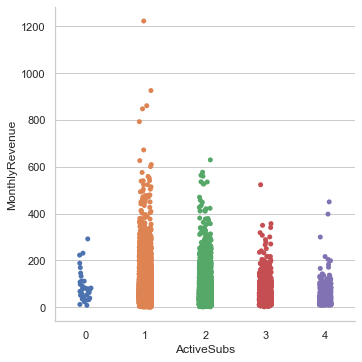

In [15]:
#use category plot to plot monthly revenue for each active subs category
sns.catplot(x='ActiveSubs',y='MonthlyRevenue', data=cust_df); 

<mark>__Result:__
    
Based on the category plot analysis, there is a negative correlation. As the number of Active Subscribers increases, the Monthly Revenue decreases. The plot also illustrates that there are customers with 0 Active Subscriptions who are still contributing to the company's monthly revenue.


### Q2.3 Does credit rating have an impact in churn rate?

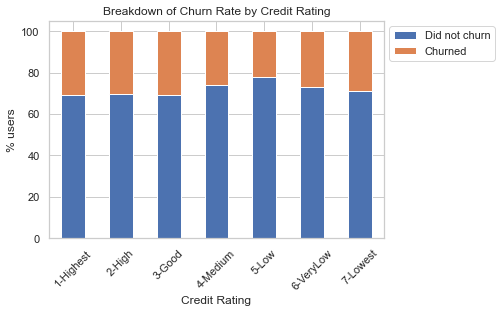

In [17]:
#Plot 100% stacked bar chart

#Create dataframe for plotting 100% stacked bar chart
df_bar = pd.crosstab(cust_df['CreditRating'], cust_df['Churn'])

stacked_data = df_bar.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True)
plt.title("Breakdown of Churn Rate by Credit Rating")
plt.xlabel("Credit Rating")
plt.xticks(rotation=45)
plt.ylabel("% users")
plt.legend(['Did not churn', 'Churned'], loc='upper left', bbox_to_anchor=(1, 1),ncol = 1)
plt.show();

<mark>__Result:__
    
As we can see from the stacked bar chart, Credit rating does not have a significant impact on Churn. There is no difference in trends between both variables.

### Analysing Customer Churn Over Time

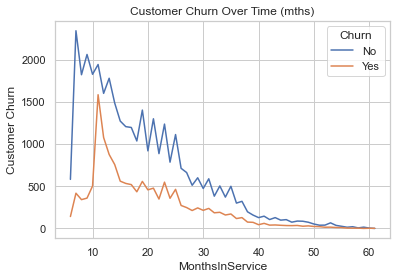

In [18]:
cols = ["MonthsInService", "Churn"]
cust_df_crosstab = pd.crosstab(index=cust_df['MonthsInService'], columns=cust_df['Churn'])
#print(cust_df_crosstab)

cust_df_crosstab.plot(kind="line")
plt.title("Customer Churn Over Time (mths)")
plt.ylabel("Customer Churn")
plt.show();

In this plot, we can see that customer churn spikes during the first 12 months (rough approximation). Based on this preliminary analysis, we recommend focusing on ways to reduce customer churn during the first 2 yrs of their contract.

In [19]:
## Gonna drop the 206 NaN in PercChangeMinutes and PercChangeRevenues
cust_df1 = cust_df.dropna(subset =['PercChangeMinutes', 'PercChangeRevenues'], how = 'all')
cust_df1.dropna(subset =['CurrentEquipmentDays'],inplace=True)

In [ ]:
cust_df1.shape # 49722 -206-1 = 49515 

## Q3. Create additional features to help predict churn

In [20]:
# Check for zero value before dividing
def div(numerator, denominator):
    return lambda row: 0.0 if row[denominator] == 0 else float(row[numerator]/row[denominator]*100)

#wrapper function to create additional features for churn prediction
def create_features(cust_df):
    
    #3.1 Percent of current active subs over total subs
    cust_df['perc_active_subs'] = cust_df['ActiveSubs'] / cust_df['UniqueSubs']*100
    
    #3.2 Percent of recurrent charge to monthly charge
    #type your code here to create a new column in cust_df
    
    cust_df.loc[:,'perc_recurrent_charge'] = cust_df.apply(div('TotalRecurringCharge','MonthlyRevenue'),axis =1)
    
    #3.3 Percent of overage minutes over total monthly minutes
    #type your code here to create a new column in cust_df
    
    cust_df.loc[:,'perc_overage_minute'] = cust_df.apply(div('OverageMinutes','MonthlyMinutes'),axis =1)
    return cust_df  

In [21]:
create_features(cust_df1) # Create additional 3 features. Updated table shape is 49515 rows with 61 columns.

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,perc_active_subs,perc_recurrent_charge,perc_overage_minute
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,30,Yes,1-Highest,Suburban,Professional,No,50.0,91.666667,0.000000
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,30,No,4-Medium,Suburban,Professional,Yes,100.0,100.058858,0.000000
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,NaN,No,3-Good,Town,Crafts,Yes,100.0,100.000000,0.000000
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,10,No,4-Medium,Other,Other,No,100.0,91.152163,0.000000
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,1,10,No,1-Highest,Other,Professional,Yes,100.0,99.183197,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51037,3399906,No,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,...,0,NaN,No,3-Good,Other,Other,Yes,100.0,53.258145,68.253968
51039,3399922,No,50.00,492.0,50.0,0.00,0.0,0.0,0.0,0.0,...,0,NaN,No,6-VeryLow,Suburban,Other,NaN,100.0,100.000000,0.000000
51040,3399942,No,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,...,0,NaN,No,1-Highest,Other,Professional,NaN,100.0,97.235727,0.552486
51041,3399946,Yes,117.49,384.0,30.0,0.00,250.0,0.0,0.0,0.0,...,0,30,No,5-Low,Other,Professional,Yes,100.0,25.534088,65.104167


In [22]:
## The 6 columns below were dropped as they had no significance to Churn after EDA. These columns also 
# contained many missing values.

list_of_col_drop1 = ['MaritalStatus', 'HandsetPrice','AgeHH1','AgeHH2','ServiceArea','CreditRating','IncomeGroup'] 

cust_df1.drop(list_of_col_drop1, axis=1,inplace=True)
cust_df1.shape # 61 cols - 7 cols = 54 cols

(49515, 54)

In [23]:
list_of_col_drop2 = ['CustomerID', 'Handsets','HandsetModels','ChildrenInHH','HandsetRefurbished','HandsetWebCapable','Homeownership',
                      'NonUSTravel','OwnsComputer','HasCreditCard','NewCellphoneUser','NotNewCellphoneUser','PrizmCode']
cust_df_final=cust_df1.drop(list_of_col_drop2, axis=1)

In [24]:
cust_df_final.shape ## Table shape update: Left with 41 columns, 49515 rows. 

(49515, 41)

### Check for NaNs and Class Balance before building the ML models 

In [25]:
print('Number of nulls in dataframe:', cust_df_final.isnull().sum().sum())

Number of nulls in dataframe: 0


In [26]:
#cust_df_final['Churn'].value_counts() # 35333 vs 14182
num_churn0, num_churn1 = cust_df_final['Churn'].value_counts()

print('Churn:',round(num_churn1/cust_df_final.shape[0]*100,2),'%\n'+'NON churn:',round(num_churn0/cust_df_final.shape[0]*100,2),'%')

Churn: 28.64 %
NON churn: 71.36 %


### We recognised that we have an imbalanced data set as the ratio of Churn : No Churn is approximately 3 : 7. Next step is to balance the data.

In [27]:
# Balance the Churn class
num_churn0, num_churn1 = cust_df_final['Churn'].value_counts()

df_churn0 = cust_df_final[cust_df_final.Churn == 'No']
df_churn1 = cust_df_final[cust_df_final.Churn == 'Yes']

#print(df_churn0.shape,df_churn1.shape )

over_samp_churn1 = df_churn1.sample(num_churn0, replace = True) # oversample for churn = 1

df_merge_rows = pd.concat([over_samp_churn1,df_churn0], axis = 0)

cust_df_final = df_merge_rows

cust_df_final.Churn.value_counts() # check if balanced

No     35333
Yes    35333
Name: Churn, dtype: int64

1:1 ratio achieved.

## Q4. Build classification model to predict customer churn month in advance

### Initial data processing for model building exercise

In [28]:
# Replace churn string values with numeric binary values
cust_df_final.replace({"Yes":1, "No":0}, inplace = True)
# Utilize pandas dummy variable function to create dummy variable series
dummy_df = pd.get_dummies(cust_df_final)
dummy_df = pd.get_dummies(cust_df_final,columns=['UniqueSubs', 'ActiveSubs','Occupation'], drop_first=True)
# We created dummy variables for these extra cols since their dtype is int                  

In [29]:
# Establish our target feature, churn, as our y feature
y = dummy_df.Churn.values
# Drop our target feature from our features dataframe
X = dummy_df.drop('Churn', axis = 1)
# Save dataframe for logistic regression 
X_train_logreg = X 

In [30]:
y=y.reshape(-1,1)
y.shape #y.ndim is 2

(70666, 1)

In [31]:
## Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state =0, stratify =y )

In [32]:
X_train.shape # 49466 rows, 51 cols
y_train.shape # 49466 rows, 1 col  
X_test.shape # 21200 rows, 51 cols
y_test.shape # 21200 rows, 1 col

(49466, 51)

(49466, 1)

(21200, 51)

(21200, 1)

## Logistic Regression 

### Q4.1 Build a simple logistic regression model to predict churn and evaluate model accuracy on test data set

In [33]:
X_train_logreg = X
# Reorder X_train columns
temp_col = X_train_logreg['perc_active_subs']
X_train_logreg = X_train_logreg.drop(columns='perc_active_subs')
X_train_logreg.insert(0, column='perc_active_subs', value=temp_col)

temp_col = X_train_logreg['perc_recurrent_charge']
X_train_logreg = X_train_logreg.drop(columns='perc_recurrent_charge')
X_train_logreg.insert(0, column='perc_recurrent_charge', value=temp_col)

temp_col = X_train_logreg['perc_overage_minute']
X_train_logreg = X_train_logreg.drop(columns='perc_overage_minute')
X_train_logreg.insert(0, column='perc_overage_minute', value=temp_col)

In [34]:
from sklearn.model_selection import train_test_split
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_train_logreg, y, test_size = .3, random_state =0, stratify =y )

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler().fit(X_train_LR.iloc[:,0:26])
X_train_LR.iloc[:,0:26] = scaler.transform(X_train_LR.iloc[:,0:26])
X_test_LR.iloc[:,0:26] = scaler.transform(X_test_LR.iloc[:,0:26])

In [36]:
#-------------------------------- Model training -------------------------------#

#type your code to build logistic regression model on training data set

from sklearn.linear_model import LogisticRegression
logreg_mod = linear_model.LogisticRegression(max_iter=1000, random_state=0) 
logreg_mod.fit(X_train_LR, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
predictions = logreg_mod.predict(X_test_LR)

In [39]:
#Evaluate model accuracy using fitted y value and actual y_test
#Evaluation metrics to be used - GINI, Precision, Recall, confusion matrix

accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', accuracy)
print(classification_report(y_test,predictions))

Accuracy: 0.5782075471698114
              precision    recall  f1-score   support

           0       0.58      0.59      0.58     10600
           1       0.58      0.57      0.57     10600

    accuracy                           0.58     21200
   macro avg       0.58      0.58      0.58     21200
weighted avg       0.58      0.58      0.58     21200



In [40]:
probabilities = logreg_mod.predict_proba(X_test_LR)
print(probabilities[:15,:])

[[0.62411976 0.37588024]
 [0.55008697 0.44991303]
 [0.36280348 0.63719652]
 [0.48032286 0.51967714]
 [0.56203102 0.43796898]
 [0.51829851 0.48170149]
 [0.53904166 0.46095834]
 [0.59598637 0.40401363]
 [0.39954636 0.60045364]
 [0.57915282 0.42084718]
 [0.62238753 0.37761247]
 [0.50176559 0.49823441]
 [0.38204617 0.61795383]
 [0.55673753 0.44326247]
 [0.51269274 0.48730726]]


In [ ]:
#Use a probability threshold to classify customers as churners and non churners (Default = 0.5)

In [41]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

scores = score_model(probabilities,0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 0 1 1 0 0 0 0 1 0 0 0 1 0 0]
[[0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [42]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores,zero_division=0)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

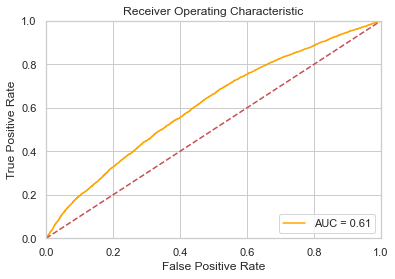

In [43]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities) 

We used the ROC curve to evaluate the accuracy of the Linear Regression model. The AUC (area under the curve) is 0.61. Since this is not that far from the baseline value of 0.5, we can deduce that this model is not useful for predicting customer churn.

In [44]:
print('The GINI coefficient is', 2*0.61 -1)

The GINI coefficient is 0.21999999999999997


In [45]:
print_metrics(y_test, scores) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive      6255              4345
Actual negative      4597              6003

Accuracy  0.58
 
           Positive      Negative
Num case    10600         10600
Precision    0.58          0.58
Recall       0.59          0.57
F1           0.58          0.57


### Q4.2 Build Random Forest classifier to compare model accuracy over the logistic regression model


In [46]:
#-------------------------------- Model training -------------------------------#
#type your code to build random forest classifier model on training data set

from sklearn.ensemble import RandomForestClassifier

rfc_300 = RandomForestClassifier(n_estimators=300,max_depth= 60,n_jobs=-1,random_state=50, oob_score = True )
rfc_300.fit(X_train, y_train)

RandomForestClassifier(max_depth=60, n_estimators=300, n_jobs=-1,
                       oob_score=True, random_state=50)

In [47]:
#-------------------------------- Model testing ---------------------------------#

#type your code here to predict for X_test data set using the fitted RF model

y_pred_rfc300 = rfc_300.predict(X_test)

#Evaluate model accuracy using fitted y value and actual y_test
#Evaluation metrics to be used - GINI, Precision, Recall, confusion matrix

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_rfc300))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     10600
           1       0.90      0.87      0.88     10600

    accuracy                           0.89     21200
   macro avg       0.89      0.89      0.89     21200
weighted avg       0.89      0.89      0.89     21200



In [48]:
y_predproba = rfc_300.predict_proba(X_test)[:,1]
y_predproba

array([0.27666667, 0.37333333, 0.94333333, ..., 0.36333333, 0.34666667,
       0.93666667])

In [49]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rfc300)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[9580 1020]
 [1410 9190]]


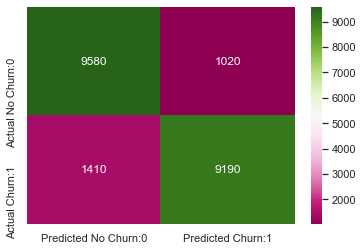

In [50]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Predicted No Churn:0', 'Predicted Churn:1'], 
                                  index=['Actual No Churn:0', 'Actual Churn:1'])

sns.heatmap(cm_matrix,annot=True, fmt='d', cmap='PiYG'); #'YlGnBu'

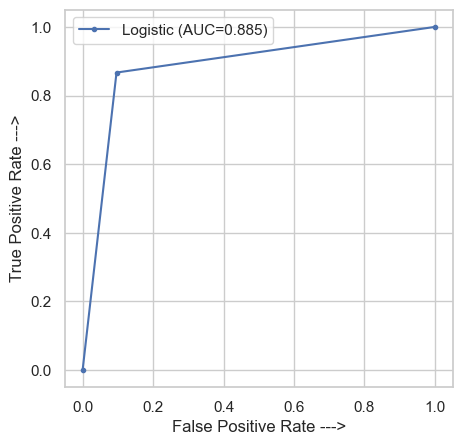

In [51]:
# Plot ROC and compare AUC
from sklearn.metrics import roc_curve,auc

rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred_rfc300)
rf_auc = auc(rf_fpr,rf_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(rf_fpr,rf_tpr,marker = '.',label='Logistic (AUC=%0.3f)' % rf_auc)

plt.xlabel('False Positive Rate --->')
plt.ylabel('True Positive Rate --->')

plt.legend()
plt.show();

In [52]:
print('The GINI coefficient is', 2*0.886-1)

The GINI coefficient is 0.772


<mark>__Result:__
    
We used the following 2  metrics to evaluate our models:
1. Recall - Besides Precision, having a higher Recall is important as False Negatives can cause the telco providers not to take actions to prevent potential churners, leading to a loss in revenues and shrink in subscriber base.
2. The Gini coefficient of the Random Forest is 0.772 compared to 0.219 showing it is a better model in accurately predicting churners.
    
2. Thus we will use the RANDOM FOREST CLASSIFIER to predict churn as it has a higher Recall of 0.87 versus the Logistic Regression model which has a Recall of 0.57.

### Q4.3 Identify most important features impacting churn

In [53]:
# Type your code here to plot the top 20 important predictor features impacting churn using the Random Forest model created

col_names = X_train.columns
rfc_300_top20 = pd.Series(rfc_300.feature_importances_,index = col_names).sort_values(ascending = False)[:20]
top20 =rfc_300_top20.sort_values(ascending = False).index.tolist() # saves list for later

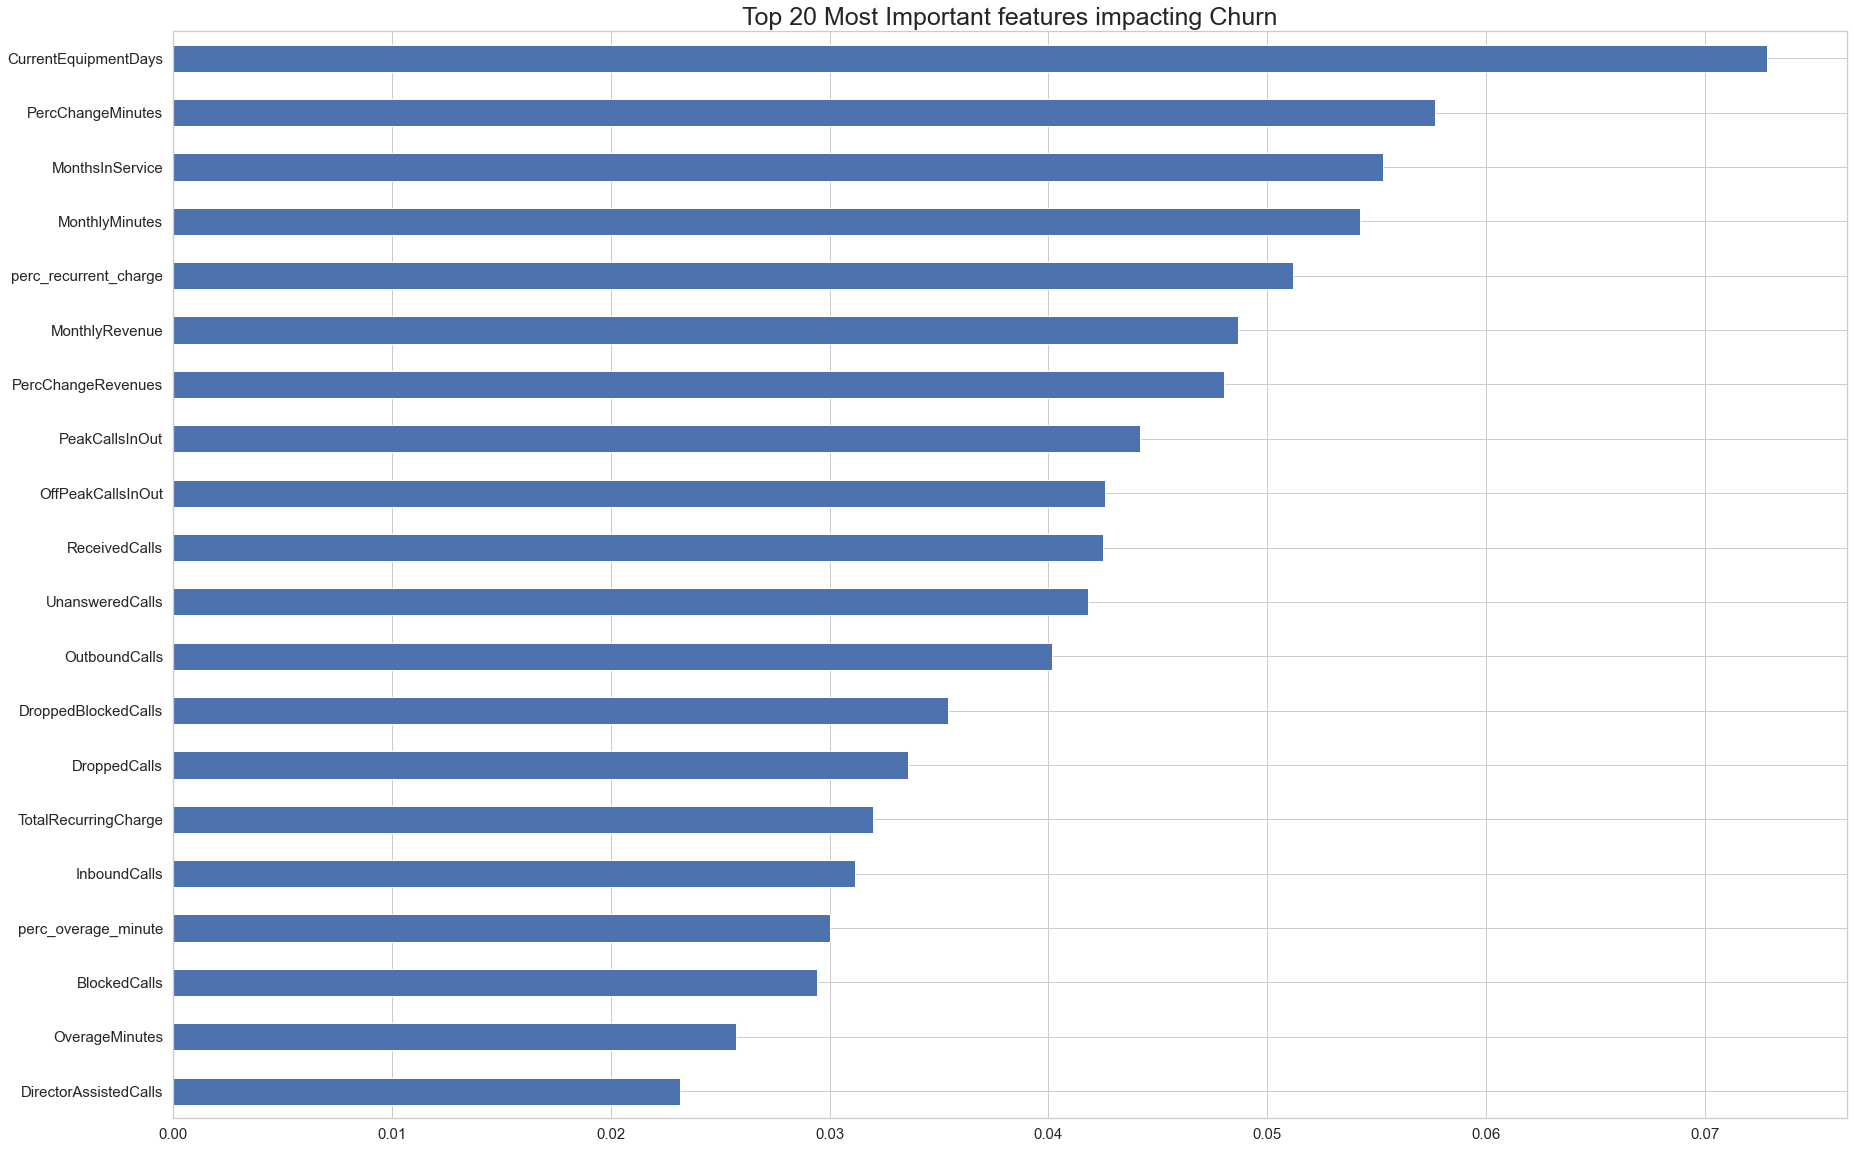

In [54]:
plt.figure(figsize = (30, 20))
rfc_300_top20.sort_values().plot.barh()
plt.title ('Top 20 Most Important features impacting Churn', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

## Q5. Use the hold out data provided to predict churners using the best model identified in step 4 

In [56]:
#Type your code here to predict churners based on the hold out data set provided
#Note #1: use "create_features(cust_df)" functions to create the additional list of features in the hold out data set
#Note #2: Also, perform feature scaling and dummy variables creation as performed during the initial stages of step #4

#Use "predict" function on the transformend data using the best fitted model object
#edit the file location of raw data set
cust_df_hold =pd.read_csv('Mini_project_3_Hold_Out_Data.csv')

In [57]:
cust_df_hold.shape # 20 000 rows, 58 columns

(20000, 58)

In [58]:
# Drop the NaNs
cust_df_hold_clean = cust_df_hold.dropna(subset =['MonthlyRevenue', 'MonthlyMinutes','PercChangeMinutes'])

In [59]:
cust_df_hold_clean.shape # 19865 x 58

(19865, 58)

In [60]:
create_features(cust_df_hold_clean) 

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,perc_active_subs,perc_recurrent_charge,perc_overage_minute
0,3000006,NaN,57.49,483.0,37.0,0.25,23.0,0.0,532.0,51.0,...,1,150,No,5-Low,Other,Other,No,100.000000,64.359019,4.761905
1,3000018,NaN,55.23,570.0,72.0,0.00,0.0,0.0,38.0,0.0,...,2,80,No,1-Highest,Other,Professional,No,100.000000,130.363933,0.000000
2,3000034,NaN,97.34,1039.0,50.0,4.95,420.0,0.0,198.0,23.3,...,3,10,No,3-Good,Suburban,Crafts,Yes,100.000000,51.366345,40.423484
3,3000070,NaN,35.59,153.0,30.0,0.00,16.0,0.0,30.0,7.3,...,1,200,No,1-Highest,Other,Other,No,66.666667,84.293341,10.457516
4,3000074,NaN,55.27,1213.0,50.0,0.74,0.0,1.3,169.0,1.0,...,0,10,No,1-Highest,Suburban,Other,No,100.000000,90.464990,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19986,3399818,NaN,30.00,321.0,30.0,0.00,0.0,0.0,0.0,0.0,...,0,30,No,3-Good,Other,Other,Yes,100.000000,100.000000,0.000000
19987,3399826,NaN,16.99,0.0,17.0,0.00,0.0,0.0,0.0,0.0,...,0,Unknown,No,1-Highest,Suburban,Professional,No,100.000000,100.058858,0.000000
19989,3399854,NaN,41.84,351.0,30.0,0.99,31.0,0.0,0.0,0.0,...,0,150,No,4-Medium,Other,Other,Yes,100.000000,71.701721,8.831909
19991,3399862,NaN,83.90,825.0,85.0,8.91,0.0,0.0,0.0,0.0,...,1,30,No,3-Good,Other,Professional,No,100.000000,101.311085,0.000000


In [61]:
cust_df_hold_20=cust_df_hold_clean.loc[:,top20]

In [62]:
cust_df_hold_20.shape # 19865 rows with 20 columns

(19865, 20)

In [63]:
cust_df_hold_20.isnull().sum().sum() # no nulls

0

In [64]:
## Ran the Random Forest again with the top 20 columns
X_train_20 = X_train.loc[:,top20]
X_test_hold = cust_df_hold_20

In [65]:
from sklearn.ensemble import RandomForestClassifier

rfc_300_top20 = RandomForestClassifier(n_estimators=300,max_depth= 60,n_jobs=-1,random_state=50, oob_score = True )
rfc_300_top20.fit(X_train_20, y_train)

RandomForestClassifier(max_depth=60, n_estimators=300, n_jobs=-1,
                       oob_score=True, random_state=50)

In [66]:
y_pred_rfc300_top20 = rfc_300_top20.predict(X_test_hold)

In [71]:
np.count_nonzero(y_pred_rfc300_top20 == 0)
np.count_nonzero(y_pred_rfc300_top20 == 1)

16961

2904

## Q6. [Bonus Question] Calculate lift chart and total monthly revenue saved by targeting top 10-20% of the customers using your best predictive model

Gains Curve Log Regression

In [ ]:
#Type your code here to plot the lift chart from the best model

skplt.metrics.plot_cumulative_gain(y_test, probabilities)
plt.show();

According to the Cumulative Gains Curve for our Logistic Regression Model, there is not much lift and therefore this model is not the best tool to predict customer churn.

In [ ]:
#Identify the lift i.e. 3x of capturing churn with and without using the model 

#(Assume: only top 20% high risk customers are to be targetted)

<mark>__Result:__
    
1. What is the % actual churn captured by targeting top 20% (top 2 deciles) of the customers sorted by their churn probability?
2. What is the total monthly revenue of actual churn customers identified in the top 20% of the customers?
   